In [20]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

!pip install scikit-surprise
from surprise import Reader, SVD, Dataset, accuracy
from surprise.model_selection import GridSearchCV, train_test_split, cross_validate

!pip install torch torchvision torchaudio
!pip install pytorch-lightning

from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

In [21]:
tag_df = pd.read_csv("/content/drive/MyDrive/tag.csv")
tag_df.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [22]:
tag_df.shape

(465564, 4)

In [23]:
tag_df.isnull().sum()

userId        0
movieId       0
tag          16
timestamp     0
dtype: int64

In [24]:


tag_df.rename(columns={'tag':'user_tag'}, inplace=True)


tag_df['timestamp'] = pd.to_datetime(tag_df['timestamp'])
tag_df['year'] = tag_df['timestamp'].dt.year
tag_df['month'] = tag_df['timestamp'].dt.month



tag_df['user_tag'] = tag_df['user_tag'].str.lower()

In [25]:
print(tag_df.head())
tag_df.shape

   userId  movieId       user_tag           timestamp  year  month
0      18     4141    mark waters 2009-04-24 18:19:40  2009      4
1      65      208      dark hero 2013-05-10 01:41:18  2013      5
2      65      353      dark hero 2013-05-10 01:41:19  2013      5
3      65      521  noir thriller 2013-05-10 01:39:43  2013      5
4      65      592      dark hero 2013-05-10 01:41:18  2013      5


(465564, 6)

In [26]:
tag_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465564 entries, 0 to 465563
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   userId     465564 non-null  int64         
 1   movieId    465564 non-null  int64         
 2   user_tag   465548 non-null  object        
 3   timestamp  465564 non-null  datetime64[ns]
 4   year       465564 non-null  int64         
 5   month      465564 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 21.3+ MB


In [27]:
tag_df.user_tag.value_counts()

sci-fi                      3576
based on a book             3307
atmospheric                 3169
comedy                      3078
action                      3068
                            ... 
touchstone                     1
pg:some brief language         1
playwright:aaron sorkin        1
screenwriter:neil labute       1
topless scene                  1
Name: user_tag, Length: 35172, dtype: int64

In [28]:

tag_df.user_tag.value_counts().head(10)


sci-fi              3576
based on a book     3307
atmospheric         3169
comedy              3078
action              3068
nudity (topless)    2646
surreal             2528
twist ending        2367
bd-r                2334
funny               2253
Name: user_tag, dtype: int64

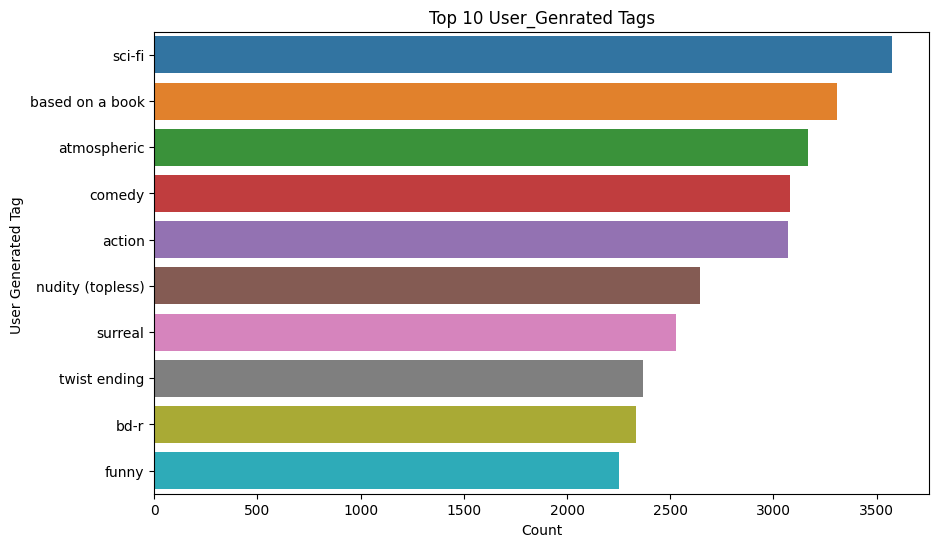

In [29]:

common_tags = tag_df['user_tag'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=common_tags.values,y=common_tags.index, orient='h')
plt.title('Top 10 User_Genrated Tags')
plt.xlabel("Count")
plt.ylabel("User Generated Tag ")
plt.show()

In [30]:
rating_df = pd.read_csv("/content/drive/MyDrive/rating.csv")
rating_df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [31]:
rating_df.shape

(20000263, 4)

In [32]:
rating_df.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [33]:

rating_df['timestamp'] = pd.to_datetime(rating_df['timestamp'])
rating_df['year'] = rating_df['timestamp'].dt.year
rating_df['month'] = rating_df['timestamp'].dt.month


In [34]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   userId     int64         
 1   movieId    int64         
 2   rating     float64       
 3   timestamp  datetime64[ns]
 4   year       int64         
 5   month      int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 915.5 MB


In [35]:
print(rating_df.head())
rating_df.shape

   userId  movieId  rating           timestamp  year  month
0       1        2     3.5 2005-04-02 23:53:47  2005      4
1       1       29     3.5 2005-04-02 23:31:16  2005      4
2       1       32     3.5 2005-04-02 23:33:39  2005      4
3       1       47     3.5 2005-04-02 23:32:07  2005      4
4       1       50     3.5 2005-04-02 23:29:40  2005      4


(20000263, 6)

In [36]:
rating_df.rating.value_counts()

4.0    5561926
3.0    4291193
5.0    2898660
3.5    2200156
4.5    1534824
2.0    1430997
2.5     883398
1.0     680732
1.5     279252
0.5     239125
Name: rating, dtype: int64

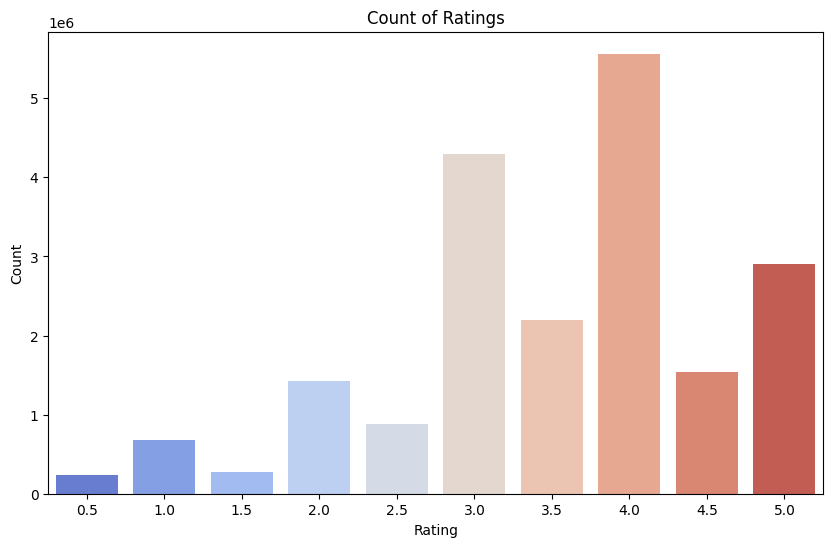

In [37]:


plt.figure(figsize=(10, 6))
sns.countplot(x='rating', data=rating_df, palette='coolwarm')
plt.title('Count of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


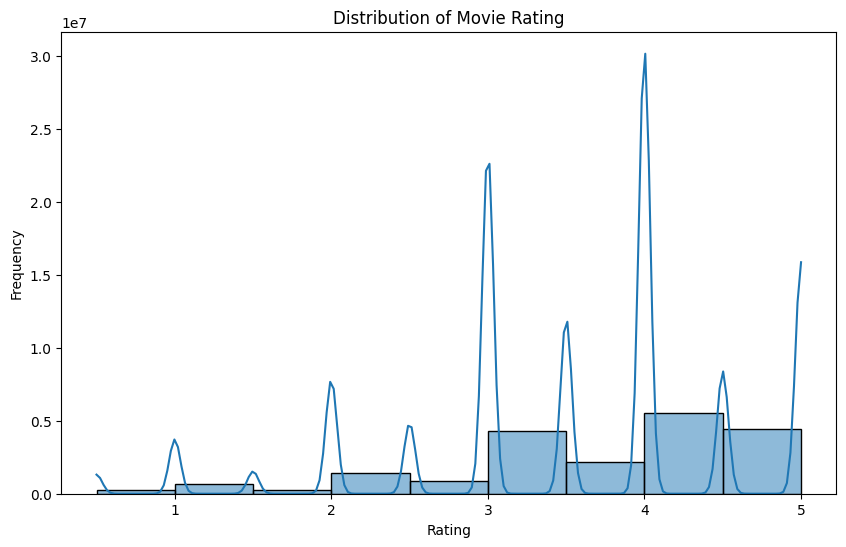

In [38]:

plt.figure(figsize=(10, 6))
sns.histplot(rating_df['rating'], bins=9, kde=True)
plt.title('Distribution of Movie Rating')
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

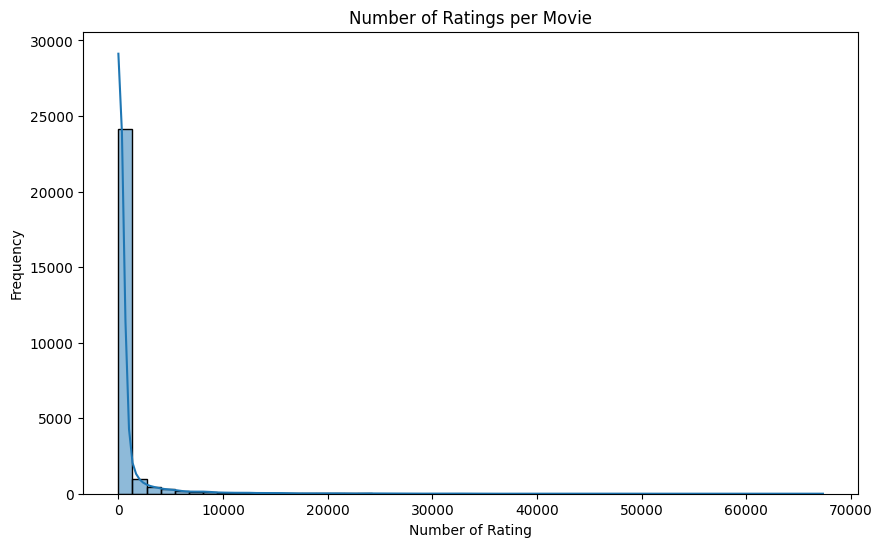

In [39]:
ratings_per_movie = rating_df.groupby('movieId')['rating'].count()
plt.figure(figsize=(10,6))
sns.histplot(ratings_per_movie, bins=50, kde=True)
plt.title('Number of Ratings per Movie')
plt.xlabel("Number of Rating")
plt.ylabel("Frequency")
plt.show()

In [40]:
movie_df = pd.read_csv("/content/drive/MyDrive/movie.csv")

In [41]:
movie_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [42]:
movie_df.shape

(27278, 3)

In [43]:
movie_df.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [44]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  27278 non-null  int64 
 1   title    27278 non-null  object
 2   genres   27278 non-null  object
dtypes: int64(1), object(2)
memory usage: 639.5+ KB


In [45]:

movie_df['genres'] = movie_df['genres'].str.split('|')
movie_df

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),[Comedy]
27274,131256,"Feuer, Eis & Dosenbier (2002)",[Comedy]
27275,131258,The Pirates (2014),[Adventure]
27276,131260,Rentun Ruusu (2001),[(no genres listed)]


In [46]:

movie_df_new = movie_df.copy()


movie_df_new['release_year'] = movie_df['title'].str.extract(r'\((\d{4})\)', expand=False)
movie_df_new['movie_title'] = movie_df['title'].str.replace(r'\(\d{4}\)', '').str.strip()


movie_df_new['genres'] = movie_df_new['genres'].str.split('|')

movie_df_new = movie_df_new.drop('title', axis=1)
movie_df_new = movie_df_new[['movieId', 'movie_title', 'release_year', 'genres']]

movie_df_new.head(10)


<ipython-input-46-6b1b1af79389>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  movie_df_new['movie_title'] = movie_df['title'].str.replace(r'\(\d{4}\)', '').str.strip()


,movieId,movie_title,release_year,genres
0,1,Toy Story,1995,NaN
1,2,Jumanji,1995,NaN
2,3,Grumpier Old Men,1995,NaN
3,4,Waiting to Exhale,1995,NaN
4,5,Father of the Bride Part II,1995,NaN
5,6,Heat,1995,NaN
6,7,Sabrina,1995,NaN
7,8,Tom and Huck,1995,NaN
8,9,Sudden Death,1995,NaN
9,10,GoldenEye,1995,NaN


In [47]:
print(movie_df_new.head())
movie_df_new.shape

   movieId                  movie_title release_year  genres
0        1                    Toy Story         1995     NaN
1        2                      Jumanji         1995     NaN
2        3             Grumpier Old Men         1995     NaN
3        4            Waiting to Exhale         1995     NaN
4        5  Father of the Bride Part II         1995     NaN


(27278, 4)

In [48]:
movie_df_new.release_year.value_counts()

2009    1113
2012    1022
2011    1016
2013    1011
2008     979
        ... 
1893       1
1901       1
1903       1
1902       1
1891       1
Name: release_year, Length: 118, dtype: int64

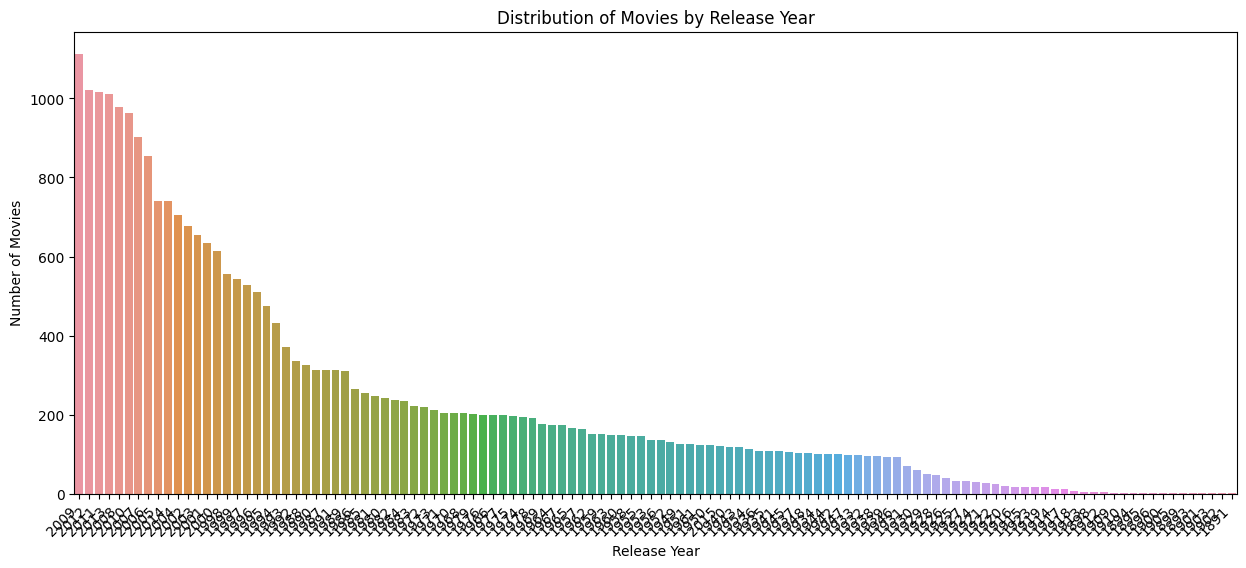

In [49]:

plt.figure(figsize=(15, 6))
sns.countplot(x='release_year', data=movie_df_new, order=movie_df_new['release_year'].value_counts().index)
plt.title('Distribution of Movies by Release Year')
plt.xlabel("Release Year")
plt.ylabel("Number of Movies")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()


In [50]:
movie_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   movieId       27278 non-null  int64  
 1   movie_title   27278 non-null  object 
 2   release_year  27256 non-null  object 
 3   genres        0 non-null      float64
dtypes: float64(1), int64(1), object(2)
memory usage: 852.6+ KB


In [51]:

movie_df_new['release_year'] = pd.to_datetime(movie_df_new['release_year'], errors='coerce')


In [52]:
movie_df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   movieId       27278 non-null  int64         
 1   movie_title   27278 non-null  object        
 2   release_year  27256 non-null  datetime64[ns]
 3   genres        0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 852.6+ KB


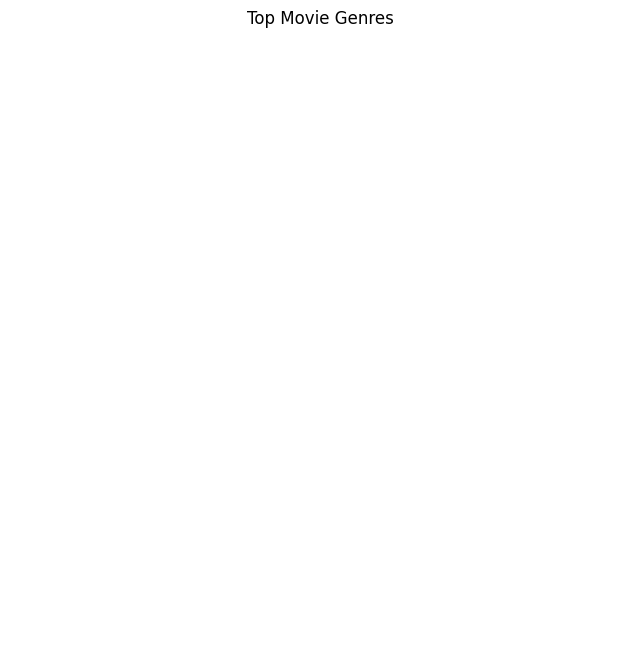

In [53]:


a = plt.cm.cool

top_genres = movie_df_new['genres'].explode().value_counts().head(10)
colors = [a(0.1), a(0.2), a(0.3), a(0.4), a(0.5), a(0.6), a(0.7), a(0.8), a(0.9), a(0.99)]


plt.figure(figsize=(8, 8))
plt.pie(top_genres.values, labels=top_genres.index, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Top Movie Genres')
plt.axis('equal')

plt.show()


In [54]:
link_df = pd.read_csv("/content/drive/MyDrive/link.csv")
link_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [55]:
link_df.shape

(27278, 3)

In [56]:
link_df.isnull().sum()

movieId      0
imdbId       0
tmdbId     252
dtype: int64

In [57]:
link_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27278 entries, 0 to 27277
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  27278 non-null  int64  
 1   imdbId   27278 non-null  int64  
 2   tmdbId   27026 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 639.5 KB


In [58]:
link_df.describe()

,movieId,imdbId,tmdbId
count,27278.000000,2.727800e+04,27026.000000
mean,59855.480570,5.781860e+05,63846.683083
std,44429.314697,7.804707e+05,69862.134497
min,1.000000,5.000000e+00,2.000000
25%,6931.250000,7.741725e+04,15936.500000
50%,68068.000000,1.524350e+05,39468.500000
75%,100293.250000,9.062715e+05,82504.000000
max,131262.000000,4.530184e+06,421510.000000


In [59]:
genome_scores_df = pd.read_csv("/content/drive/MyDrive/genome_scores.csv")
genome_scores_df.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [60]:
genome_scores_df.shape

(11709768, 3)

In [61]:
genome_scores_df.isnull().sum()

movieId      0
tagId        0
relevance    0
dtype: int64

In [62]:
genome_scores_df.rename(columns={'tagId':'genome_tag_Id'}, inplace=True)

In [63]:
genome_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11709768 entries, 0 to 11709767
Data columns (total 3 columns):
 #   Column         Dtype  
---  ------         -----  
 0   movieId        int64  
 1   genome_tag_Id  int64  
 2   relevance      float64
dtypes: float64(1), int64(2)
memory usage: 268.0 MB


In [64]:
genome_scores_df.describe().round(2)

,movieId,genome_tag_Id,relevance
count,11709768.00,11709768.00,11709768.00
mean,25842.97,564.50,0.12
std,34676.15,325.63,0.15
min,1.00,1.00,0.00
25%,2926.00,282.75,0.02
50%,6017.00,564.50,0.06
75%,46062.00,846.25,0.14
max,131170.00,1128.00,1.00


In [65]:
genome_tags_df = pd.read_csv("/content/drive/MyDrive/genome_tags.csv")
genome_tags_df

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
...,...,...
1123,1124,writing
1124,1125,wuxia
1125,1126,wwii
1126,1127,zombie


In [66]:
genome_tags_df.shape

(1128, 2)

In [67]:
genome_tags_df.rename(columns={'tag':'genome_tag'}, inplace=True)

genome_tags_df.rename(columns={'tagId':'genome_tag_Id'}, inplace=True)

In [68]:
genome_tags_df.isnull().sum()

genome_tag_Id    0
genome_tag       0
dtype: int64

In [69]:
genome_tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   genome_tag_Id  1128 non-null   int64 
 1   genome_tag     1128 non-null   object
dtypes: int64(1), object(1)
memory usage: 17.8+ KB


In [70]:
print(tag_df.head())
print(rating_df.head())
print(movie_df.head())
print(link_df.head())
print(genome_scores_df.head())
print(genome_tags_df.head())

   userId  movieId       user_tag           timestamp  year  month
0      18     4141    mark waters 2009-04-24 18:19:40  2009      4
1      65      208      dark hero 2013-05-10 01:41:18  2013      5
2      65      353      dark hero 2013-05-10 01:41:19  2013      5
3      65      521  noir thriller 2013-05-10 01:39:43  2013      5
4      65      592      dark hero 2013-05-10 01:41:18  2013      5
   userId  movieId  rating           timestamp  year  month
0       1        2     3.5 2005-04-02 23:53:47  2005      4
1       1       29     3.5 2005-04-02 23:31:16  2005      4
2       1       32     3.5 2005-04-02 23:33:39  2005      4
3       1       47     3.5 2005-04-02 23:32:07  2005      4
4       1       50     3.5 2005-04-02 23:29:40  2005      4
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhal

In [71]:

data = pd.merge(movie_df,rating_df, how='inner', on="movieId")

In [72]:
data

,movieId,title,genres,userId,rating,timestamp,year,month
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3,4.0,1999-12-11 13:36:47,1999,12
1,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",6,5.0,1997-03-13 17:50:52,1997,3
2,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",8,4.0,1996-06-05 13:37:51,1996,6
3,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",10,4.0,1999-11-25 02:44:47,1999,11
4,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",11,4.5,2009-01-02 01:13:41,2009,1
...,...,...,...,...,...,...,...,...
20000258,131254,Kein Bund für's Leben (2007),[Comedy],79570,4.0,2015-03-30 19:32:59,2015,3
20000259,131256,"Feuer, Eis & Dosenbier (2002)",[Comedy],79570,4.0,2015-03-30 19:48:08,2015,3
20000260,131258,The Pirates (2014),[Adventure],28906,2.5,2015-03-30 19:56:32,2015,3
20000261,131260,Rentun Ruusu (2001),[(no genres listed)],65409,3.0,2015-03-30 19:57:46,2015,3


In [73]:

def missing_values_analysis(data):
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=True)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=True)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['Total Missing Values', 'Ratio'])
    missing_df = pd.DataFrame(missing_df)
    return missing_df

def check_df(data, row_num=5, col_num=10):
    print("*************** Dataset Shape ***************")
    print("No. of Rows:", data.shape[0], "\nNo. of Columns:", data.shape[1])
    print("*************** Dataset Information ***************")
    print(data.info())
    print("*************** Types of Columns ***************")
    print(data.dtypes)
    print(f"*************** First {row_num} Rows ***************")
    print(data.iloc[:row_num,:col_num])
    print(f"*************** Last {row_num} Rows ***************")
    print(data.iloc[-row_num:,:col_num])
    print("*************** Summary Statistics of The Dataset ***************")
    print(data.describe([0.10, 0.25, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]).T)
    print("*************** Dataset Missing Values Analysis ***************")
    print(missing_values_analysis(data))


check_df(data)


*************** Dataset Shape ***************
No. of Rows: 20000263 
No. of Columns: 8
*************** Dataset Information ***************
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000263 entries, 0 to 20000262
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   movieId    int64         
 1   title      object        
 2   genres     object        
 3   userId     int64         
 4   rating     float64       
 5   timestamp  datetime64[ns]
 6   year       int64         
 7   month      int64         
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 1.3+ GB
None
*************** Types of Columns ***************
movieId               int64
title                object
genres               object
userId                int64
rating              float64
timestamp    datetime64[ns]
year                  int64
month                 int64
dtype: object
*************** First 5 Rows ***************
   movieId         

In [74]:
eda_data = pd.merge(movie_df_new,rating_df, how='inner', on="movieId")
eda_data

,movieId,movie_title,release_year,genres,userId,rating,timestamp,year,month
0,1,Toy Story,1995-01-01,NaN,3,4.0,1999-12-11 13:36:47,1999,12
1,1,Toy Story,1995-01-01,NaN,6,5.0,1997-03-13 17:50:52,1997,3
2,1,Toy Story,1995-01-01,NaN,8,4.0,1996-06-05 13:37:51,1996,6
3,1,Toy Story,1995-01-01,NaN,10,4.0,1999-11-25 02:44:47,1999,11
4,1,Toy Story,1995-01-01,NaN,11,4.5,2009-01-02 01:13:41,2009,1
...,...,...,...,...,...,...,...,...,...
20000258,131254,Kein Bund für's Leben,2007-01-01,NaN,79570,4.0,2015-03-30 19:32:59,2015,3
20000259,131256,"Feuer, Eis & Dosenbier",2002-01-01,NaN,79570,4.0,2015-03-30 19:48:08,2015,3
20000260,131258,The Pirates,2014-01-01,NaN,28906,2.5,2015-03-30 19:56:32,2015,3
20000261,131260,Rentun Ruusu,2001-01-01,NaN,65409,3.0,2015-03-30 19:57:46,2015,3


In [75]:
eda_data.isnull().sum()

movieId                0
movie_title            0
release_year         405
genres          20000263
userId                 0
rating                 0
timestamp              0
year                   0
month                  0
dtype: int64

In [76]:

top_rated_movies = eda_data.groupby(['movie_title'])['rating'].mean().sort_values(ascending=False)
top_rated_movies


movie_title
Bandaged                                    5.0
Flight of the Conchords: A Texan Odyssey    5.0
Divorce                                     5.0
Sierra, La                                  5.0
1971                                        5.0
                                           ... 
Exit to Hell                                0.5
Quest for a Heart (Röllin sydän)            0.5
Excuse Me for Living                        0.5
Rabid Grannies (Mémés cannibales, Les)      0.5
Mega Piranha                                0.5
Name: rating, Length: 25718, dtype: float64

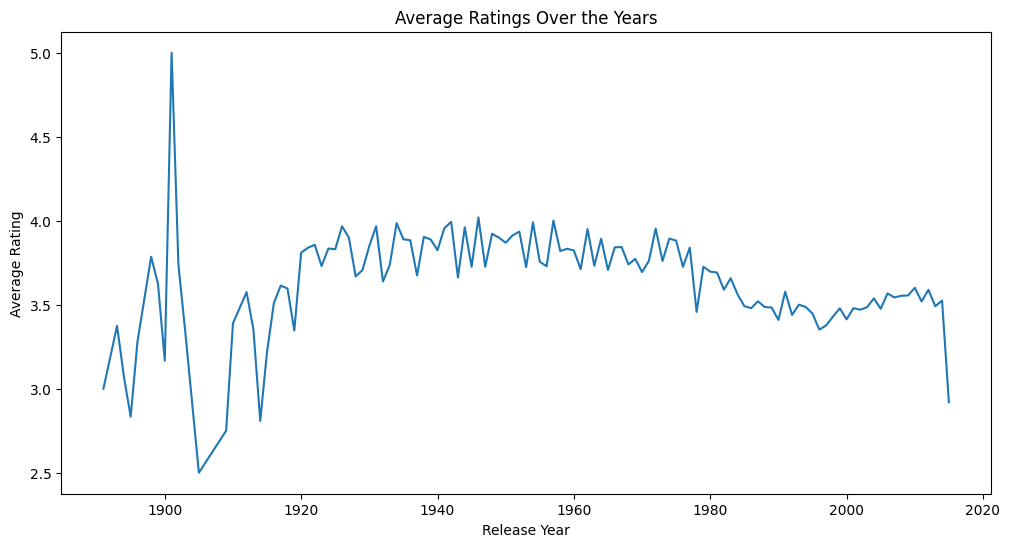

In [77]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year', y='rating', data=eda_data.groupby('release_year')['rating'].mean().reset_index())
plt.title('Average Ratings Over the Years')
plt.xlabel("Release Year")
plt.ylabel("Average Rating")
plt.show()

<ipython-input-78-c0ea3e3fcd7b>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='month', y='rating', data=eda_data, ci=None, palette='coolwarm')


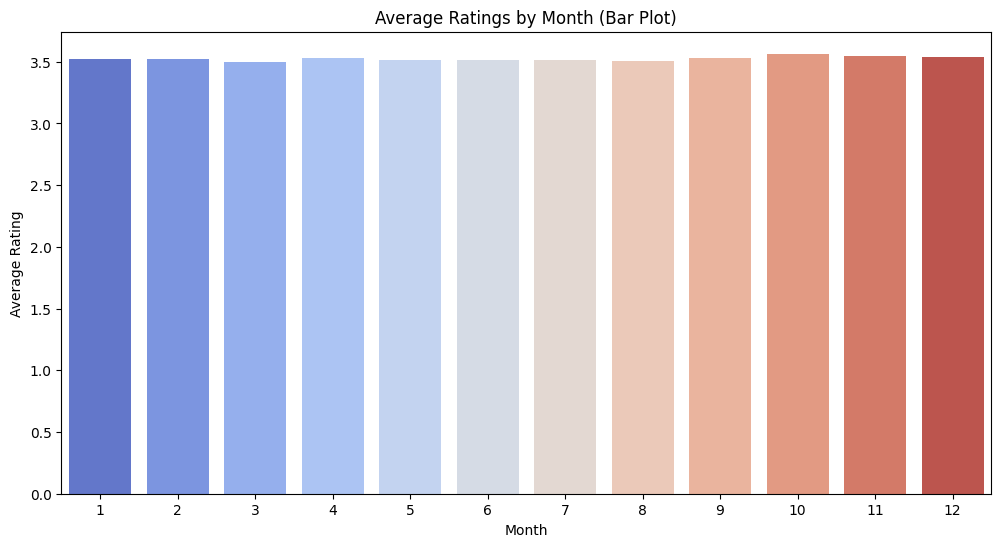

In [78]:
plt.figure(figsize=(12, 6))
sns.barplot(x='month', y='rating', data=eda_data, ci=None, palette='coolwarm')
plt.title('Average Ratings by Month (Bar Plot)')
plt.xlabel("Month")
plt.ylabel("Average Rating")
plt.show()

In [79]:
num_rating_df = data.groupby('title').count()['rating'].reset_index()
num_rating_df.rename(columns={'rating':'num_ratings'},inplace=True)
num_rating_df

,title,num_ratings
0,#chicagoGirl: The Social Network Takes on a Di...,3
1,$ (Dollars) (1971),24
2,$5 a Day (2008),39
3,$9.99 (2008),55
4,$ellebrity (Sellebrity) (2012),2
...,...,...
26724,À propos de Nice (1930),4
26725,Árido Movie (2005),1
26726,Åsa-Nisse - Wälkom to Knohult (2011),2
26727,Üvegtigris (2001),1


In [80]:
avg_rating_df = data.groupby('title')['rating'].mean().reset_index()
avg_rating_df.rename(columns={'rating':'avg_ratings'}, inplace=True)
avg_rating_df

,title,avg_ratings
0,#chicagoGirl: The Social Network Takes on a Di...,3.666667
1,$ (Dollars) (1971),2.833333
2,$5 a Day (2008),2.871795
3,$9.99 (2008),3.009091
4,$ellebrity (Sellebrity) (2012),2.000000
...,...,...
26724,À propos de Nice (1930),3.125000
26725,Árido Movie (2005),2.000000
26726,Åsa-Nisse - Wälkom to Knohult (2011),1.500000
26727,Üvegtigris (2001),3.000000


In [81]:
avg_rating_df = data.groupby('title')['rating'].mean().reset_index()
avg_rating_df.rename(columns={'rating':'avg_ratings'}, inplace=True)
avg_rating_df

,title,avg_ratings
0,#chicagoGirl: The Social Network Takes on a Di...,3.666667
1,$ (Dollars) (1971),2.833333
2,$5 a Day (2008),2.871795
3,$9.99 (2008),3.009091
4,$ellebrity (Sellebrity) (2012),2.000000
...,...,...
26724,À propos de Nice (1930),3.125000
26725,Árido Movie (2005),2.000000
26726,Åsa-Nisse - Wälkom to Knohult (2011),1.500000
26727,Üvegtigris (2001),3.000000


In [82]:
popular_movies_df = num_rating_df.merge(avg_rating_df,on='title')
popular_movies_df

,title,num_ratings,avg_ratings
0,#chicagoGirl: The Social Network Takes on a Di...,3,3.666667
1,$ (Dollars) (1971),24,2.833333
2,$5 a Day (2008),39,2.871795
3,$9.99 (2008),55,3.009091
4,$ellebrity (Sellebrity) (2012),2,2.000000
...,...,...,...
26724,À propos de Nice (1930),4,3.125000
26725,Árido Movie (2005),1,2.000000
26726,Åsa-Nisse - Wälkom to Knohult (2011),2,1.500000
26727,Üvegtigris (2001),1,3.000000


In [83]:
popular_movies_df = popular_movies_df[popular_movies_df['num_ratings']>=300].sort_values('avg_ratings',ascending=False).head(50)
popular_movies_df.merge(movie_df,on='title').drop_duplicates('title').shape

popular_movies_df

,title,num_ratings,avg_ratings
20779,"Shawshank Redemption, The (1994)",63366,4.446990
9586,"Godfather, The (1972)",41355,4.364732
24967,"Usual Suspects, The (1995)",47006,4.334372
20317,Schindler's List (1993),50054,4.310175
9587,"Godfather: Part II, The (1974)",27398,4.275641
20600,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180
19203,Rear Window (1954),17449,4.271334
2072,Band of Brothers (2001),4305,4.263182
4236,Casablanca (1942),24349,4.258327
22420,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),6525,4.256935


In [84]:
popular_movies_df.head(10)

,title,num_ratings,avg_ratings
20779,"Shawshank Redemption, The (1994)",63366,4.446990
9586,"Godfather, The (1972)",41355,4.364732
24967,"Usual Suspects, The (1995)",47006,4.334372
20317,Schindler's List (1993),50054,4.310175
9587,"Godfather: Part II, The (1974)",27398,4.275641
20600,Seven Samurai (Shichinin no samurai) (1954),11611,4.274180
19203,Rear Window (1954),17449,4.271334
2072,Band of Brothers (2001),4305,4.263182
4236,Casablanca (1942),24349,4.258327
22420,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),6525,4.256935


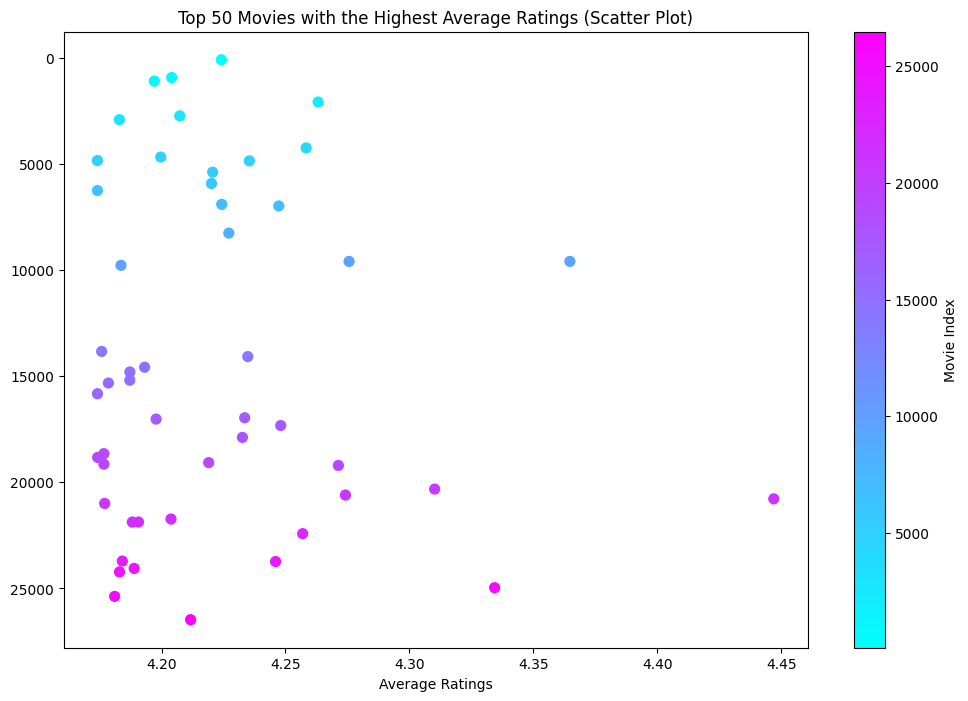

In [85]:
top_50_movies = popular_movies_df.head(50)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(top_50_movies['avg_ratings'], top_50_movies.index, c=top_50_movies.index, cmap='cool', s=50)
plt.xlabel('Average Ratings')
plt.title('Top 50 Movies with the Highest Average Ratings (Scatter Plot)')
plt.gca().invert_yaxis()
plt.colorbar(label='Movie Index', orientation='vertical')

plt.show()

In [ ]:
#!pip install --upgrade keras tensorflow


**Matrix** **Factorization**

* We use the movies dataset and rating dataset, we then merge and check if all the data match. ​

* We then define a list of movies, It begins by filtering a DataFrame for certain movies, then produces a Surprise dataset and divides it into training and test sets. ​

* This data is used to train the SVD model, which is then assessed using RMSE. Finally, it predicts a rating for a given user-item pair, illustrating how the model may be employed to predict user preferences for movies.

In [15]:
movie = pd.read_csv('/content/drive/MyDrive/movie.csv')
rating = pd.read_csv('/content/drive/MyDrive/rating.csv')
df = movie.merge(rating, how="left", on="movieId")
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


In [16]:
def check_df(dataframe, head=5):
    print(" SHAPE ".center(70,'-'))
    print('Rows: {}'.format(dataframe.shape[0]))
    print('Columns: {}'.format(dataframe.shape[1]))
    print(" TYPES ".center(70,'-'))
    print(dataframe.dtypes)
    print(" HEAD ".center(70,'-'))
    print(dataframe.head(head))
    print(" TAIL ".center(70,'-'))
    print(dataframe.tail(head))
    print(" MISSING VALUES ".center(70,'-'))
    print(dataframe.isnull().sum())
    print(" DUPLICATED VALUES ".center(70,'-'))
    print(dataframe.duplicated().sum())
    print(" DESCRIBE ".center(70,'-'))
    print(dataframe.describe([0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1]).T)

check_df(df)

------------------------------- SHAPE --------------------------------
Rows: 20000797
Columns: 6
------------------------------- TYPES --------------------------------
movieId        int64
title         object
genres        object
userId       float64
rating       float64
timestamp     object
dtype: object
-------------------------------- HEAD --------------------------------
   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating            timestamp  
0     3.0     4.0  1999-12-11 13:36:47  
1     6.0     5.0  1997-03-13 17:50:52  
2     8.0     4.0  1996-06-05 13:37

In [17]:
selected_movie_ids = [1, 131254, 4422, 131262]

selected_movies = ["Toy Story (1995)",
                   "Kein Bund für's Leben (2007)",
                   "Forrest Gump (1994)",
                   "Innocence (2014)"]
selected_movies_df = df[df.movieId.isin(selected_movie_ids)]

selected_movies_df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,3.0,4.0,1999-12-11 13:36:47
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,6.0,5.0,1997-03-13 17:50:52
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8.0,4.0,1996-06-05 13:37:51
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,10.0,4.0,1999-11-25 02:44:47
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11.0,4.5,2009-01-02 01:13:41


In [18]:
selected_movies_df.shape

(50341, 6)

In [87]:
from surprise import Reader, SVD, Dataset, accuracy
rating_scale = (1, 5)

surprise_data = selected_movies_df[['userId', 'movieId', 'rating']]
surprise_reader = Reader(rating_scale=rating_scale)
surprise_data = Dataset.load_from_df(surprise_data, surprise_reader)

In [88]:

trainset, testset = train_test_split(surprise_data, test_size=.25)
svd_model = SVD()
svd_model.fit(trainset)

In [89]:
from surprise import accuracy

predictions = svd_model.test(testset)

rmse = accuracy.rmse(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

RMSE: 0.8915
Root Mean Squared Error (RMSE): 0.8915322744168964


In [90]:
user_id = 1.0
item_id = 1
prediction = svd_model.predict(uid=user_id, iid=item_id, verbose=True)

print(f"User ID: {prediction.uid}")
print(f"Item ID: {prediction.iid}")
print(f"True Rating: {prediction.r_ui}")
print(f"Estimated Rating: {prediction.est}")
print(f"Details: {prediction.details}")


user: 1.0        item: 1          r_ui = None   est = 3.92   {'was_impossible': False}
User ID: 1.0
Item ID: 1
True Rating: None
Estimated Rating: 3.9157545232644577
Details: {'was_impossible': False}


In [91]:
user_id = 1.0
item_id = 4422
prediction = svd_model.predict(uid=user_id, iid=item_id, verbose=True)

print(f"User ID: {prediction.uid}")
print(f"Item ID: {prediction.iid}")
print(f"True Rating: {prediction.r_ui}")
print(f"Estimated Rating: {prediction.est}")
print(f"Details: {prediction.details}")


user: 1.0        item: 4422       r_ui = None   est = 3.98   {'was_impossible': False}
User ID: 1.0
Item ID: 4422
True Rating: None
Estimated Rating: 3.9775186458299068
Details: {'was_impossible': False}


In [92]:

user_1_ratings = selected_movies_df[selected_movies_df["userId"] == 1]
print(user_1_ratings)

Empty DataFrame
Columns: [movieId, title, genres, userId, rating, timestamp]
Index: []


In [93]:
param_grid = {'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005, 0.007]}


gs = GridSearchCV(SVD,
                  param_grid,
                  measures=['rmse', 'mae'],
                  cv=3,
                  n_jobs=-1,
                  joblib_verbose=True)

gs.fit(surprise_data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:    4.5s finished


In [94]:
gs.best_score['rmse']

0.8912089708824755

In [95]:
gs.best_params['rmse']

{'n_epochs': 5, 'lr_all': 0.002}

In [96]:
svd_model.n_epochs

20

In [97]:
svd_model = SVD(**gs.best_params['rmse'])

surprise_data = surprise_data.build_full_trainset()
svd_model.fit(surprise_data)



In [98]:
svd_model.predict(uid=1.0, iid=1, verbose=True)

user: 1.0        item: 1          r_ui = None   est = 3.92   {'was_impossible': False}


Prediction(uid=1.0, iid=1, r_ui=None, est=3.921935068078922, details={'was_impossible': False})

In [99]:
svd_model.predict(uid=1.0, iid=130219, verbose=True)

user: 1.0        item: 130219     r_ui = None   est = 3.92   {'was_impossible': False}


Prediction(uid=1.0, iid=130219, r_ui=None, est=3.921852962793747, details={'was_impossible': False})

# **Item Based Collaborative Filtering**



**Our Approach**



* Our first step is to merge the movies dataset and the ratings dataset and to check the merged dataset to make sure that there a no errors or mismatch in the merge function. ​

* We then count the number of times a movie's title occurs. We also try and understand what are some rare movies that users might have not seen. ​

* Then we choose movies that are not on the list of rare movies, essentially filtering out rare movies.​

* Then we establish a boolean mask in which movies in rare_movies are tagged as False while others are marked as True.​

* The data is then restructured using a pivot table, which has userId as rows, movie names ("title") as columns, and their related ratings as cell values.​

* This is a common user-item interaction matrix structure used in collaborative filtering.​

* We the correlation between the selected film (The Matrix) and all other films in the restructured dataset. It use the corrwith function to compute pairwise correlation between two DataFrame objects' rows or columns.

* The results are sorted in descending order (ascending=False), with the top ten showing. The final result displays the top ten movies based on user ratings that are most comparable to "The Matrix," with "The Matrix" having a perfect correlation of 1.000000.​

In [101]:
movie_1 = pd.read_csv('/content/drive/MyDrive/movie.csv')
rating_1 = pd.read_csv('/content/drive/MyDrive/rating.csv')

In [102]:
df_merged = movie_1.merge(rating_1, how="left", on="movieId")

In [103]:
def check_df(dataframe, head=5):
    print('Shape')
    print(dataframe.shape)
    print('Types')
    print(dataframe.dtypes)
    print('Head')
    print(dataframe.head(head))
    print('Tail')
    print(dataframe.tail(head))
    print('Null Values')
    print(dataframe.isnull().sum())
    print('Quantiles')
    print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df_merged)

Shape
(20000797, 6)
Types
movieId        int64
title         object
genres        object
userId       float64
rating       float64
timestamp     object
dtype: object
Head
   movieId             title                                       genres  \
0        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
2        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
3        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
4        1  Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   

   userId  rating            timestamp  
0     3.0     4.0  1999-12-11 13:36:47  
1     6.0     5.0  1997-03-13 17:50:52  
2     8.0     4.0  1996-06-05 13:37:51  
3    10.0     4.0  1999-11-25 02:44:47  
4    11.0     4.5  2009-01-02 01:13:41  
Tail
          movieId                          title                    genres  \
20000792   131254   Kein Bund für's L

In [104]:
movie_df_counts = pd.DataFrame(df_merged["title"].value_counts())
movie_df_counts.head(20)

,title
Pulp Fiction (1994),67310
Forrest Gump (1994),66172
"Shawshank Redemption, The (1994)",63366
"Silence of the Lambs, The (1991)",63299
Jurassic Park (1993),59715
Star Wars: Episode IV - A New Hope (1977),54502
Braveheart (1995),53769
Terminator 2: Judgment Day (1991),52244
"Matrix, The (1999)",51334
Schindler's List (1993),50054


In [105]:
rare_movies = movie_df_counts[movie_df_counts["title"] <= 1000].index
rare_movies

Index(['Bear, The (Ours, L') (1988)', 'Rosewood (1997)', 'Ted (2012)',
       'One Night at McCool's (2001)', 'Marked for Death (1990)',
       'Three to Tango (1999)', 'Adam's Rib (1949)',
       'I Now Pronounce You Chuck and Larry (2007)',
       'Italian for Beginners (Italiensk for begyndere) (2000)',
       'Husbands and Wives (1992)',
       ...
       'Satan's Sword (Daibosatsu tôge) (1960)',
       'Blind Massage (Tui na) (2014)', 'Prêt à tout (2014)',
       'Ditchdigger's Daughters, The (1997)', 'A.K. (1985)',
       'Rapture (Arrebato) (1980)',
       'Education of Mohammad Hussein, The (2013)', 'Satanas (2007)',
       'Psychosis (2010)', 'Innocence (2014)'],
      dtype='object', length=24103)

In [106]:
common_movies = df_merged[~df_merged["title"].isin(rare_movies)]

In [107]:
common_movies["title"].nunique()

3159

In [108]:
df_merged["title"].nunique()

27262

In [109]:
user_movie_df = common_movies.pivot_table(index=["userId"], columns=["title"], values="rating")

In [110]:
user_movie_df.shape

(138493, 3159)

In [111]:
user_movie_df.columns

Index([''burbs, The (1989)', '(500) Days of Summer (2009)',
       '*batteries not included (1987)', '...And Justice for All (1979)',
       '10 Things I Hate About You (1999)', '10,000 BC (2008)',
       '101 Dalmatians (1996)',
       '101 Dalmatians (One Hundred and One Dalmatians) (1961)',
       '102 Dalmatians (2000)', '12 Angry Men (1957)',
       ...
       'Zero Dark Thirty (2012)', 'Zero Effect (1998)', 'Zodiac (2007)',
       'Zombieland (2009)', 'Zoolander (2001)', 'Zulu (1964)', '[REC] (2007)',
       'eXistenZ (1999)', 'xXx (2002)', '¡Three Amigos! (1986)'],
      dtype='object', name='title', length=3159)

In [112]:
movie_name1 = "Mission: Impossible (1996)"

In [113]:
movie_name = user_movie_df[movie_name1]

In [114]:
user_movie_df.corrwith(movie_name).sort_values(ascending=False).head(10)

title
Mission: Impossible (1996)                     1.000000
Mission: Impossible III (2006)                 0.546713
Mission: Impossible II (2000)                  0.505765
Mission: Impossible - Ghost Protocol (2011)    0.476099
Cocktail (1988)                                0.441352
GoldenEye (1995)                               0.426756
Tomorrow Never Dies (1997)                     0.418250
Top Gun (1986)                                 0.408289
World Is Not Enough, The (1999)                0.405434
Ocean's Eleven (2001)                          0.400077
dtype: float64

In [115]:
movie_name2 = "Batman & Robin (1997)"

In [116]:
movie_name = user_movie_df[movie_name2]

In [117]:
user_movie_df.corrwith(movie_name).sort_values(ascending=False).head(10)

title
Batman & Robin (1997)                      1.000000
Batman Forever (1995)                      0.620899
Catwoman (2004)                            0.620201
First Kid (1996)                           0.572027
Man of the House (1995)                    0.541543
Speed 2: Cruise Control (1997)             0.538331
Superman IV: The Quest for Peace (1987)    0.517121
D3: The Mighty Ducks (1996)                0.515045
Jack Frost (1998)                          0.513860
Universal Soldier: The Return (1999)       0.513829
dtype: float64

## **Deep Learning based Recommendation System**




**Explanation**

* Implicit feedback - Indirect feedback is gathered via user interactions and serves as a substitute for user preference. Videos you view on YouTube, for example, are utilized as implicit feedback to customize suggestions to you, even if you don't rate the videos directly.​

* Implicit feedback also allows us to tailor recommendations in real time, with every click and interaction​

* The Neural Network-based Collaborative Filtering (CF) model employs a deep learning method for recommendation systems. ​

* Using implicit feedback, we will train a recommender system. We siimply binarize the ratings such that they are '1' (i.e. positive class) to transform this dataset into an implicit feedback dataset. The number '1' indicates that the user watched the movie.​

* This approach represents users and items as embeddings, which are low-dimensional vectors that capture their attributes. ​

* The embeddings of the user and items are fed into a neural network, which learns to predict ratings based on these embeddings. ​

* When compared to standard matrix factorization algorithms, our method captures complicated and non-linear interactions between users and things, resulting in more accurate suggestions.​





In [2]:

np.random.seed(123)

In [4]:
ratings_2 = pd.read_csv('/content/drive/MyDrive/rating.csv', parse_dates=['timestamp'])

In [5]:
rand_user = np.random.choice(ratings_2['userId'].unique(),size=int(len(ratings_2['userId'].unique())*0.3),replace=False)

ratings_2 = ratings_2.loc[ratings_2['userId'].isin(rand_user)]

print('There are {} rows of data from {} users'.format(len(ratings_2), len(rand_user)))

There are 6027314 rows of data from 41547 users


In [6]:
ratings_2.sample(10)

,userId,movieId,rating,timestamp
3840312,26182,3704,4.0,2007-01-31 21:56:52
7608731,52439,3365,4.0,2004-03-21 08:02:56
19363634,134060,1027,3.0,2003-07-15 22:43:45
17181947,118860,2629,1.0,2007-11-29 21:27:08
9344779,64638,4723,2.0,2001-09-10 20:11:41
10356404,71637,3882,0.5,2004-02-20 01:48:53
962965,6460,11,4.0,1996-10-22 12:53:32
12014375,82949,54001,4.5,2010-08-06 16:39:25
10532053,72855,7158,2.5,2011-07-25 01:07:58
18710288,129551,1228,4.5,2007-06-28 00:17:42


In [7]:
ratings_2['rank_latest'] = ratings_2.groupby(['userId'])['timestamp'] \
                                .rank(method='first', ascending=False)

train_ratings = ratings_2[ratings_2['rank_latest'] != 1]
test_ratings = ratings_2[ratings_2['rank_latest'] == 1]


train_ratings = train_ratings[['userId', 'movieId', 'rating']]
test_ratings = test_ratings[['userId', 'movieId', 'rating']]

In [8]:
train_ratings.loc[:, 'rating'] = 1

train_ratings.sample(10)

<ipython-input-8-ff599dc69d69>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_ratings.loc[:, 'rating'] = 1


,userId,movieId,rating
3411906,23263,5481,1
1815983,12245,5464,1
16198592,112109,6,1
13914487,96124,1247,1
1445807,9790,1690,1
11467559,79181,1757,1
1764803,11940,5673,1
18402598,127366,64839,1
1029887,6976,69746,1
4867506,33444,1960,1


Below Code:

* It gathers all unique movie IDs before iterating over user-movie combinations and marking each as a "positive" interaction.

* It creates four 'negative' samples (movies not interacted with by the user) for each positive case.

* The technique generates a balanced dataset including both positive and negative instances, which is critical for training useful recommendation system

In [9]:

all_movieIds = ratings_2['movieId'].unique()

users, items, labels = [], [], []

user_item_set = set(zip(train_ratings['userId'], train_ratings['movieId']))

num_negatives = 4

for (u, i) in tqdm(user_item_set):
    users.append(u)
    items.append(i)
    labels.append(1)
    for _ in range(num_negatives):
        negative_item = np.random.choice(all_movieIds)
        while (u, negative_item) in user_item_set:
            negative_item = np.random.choice(all_movieIds)
        users.append(u)
        items.append(negative_item)
        labels.append(0)

100%|██████████| 5985767/5985767 [05:30<00:00, 18098.71it/s]


 * It starts with user ratings and movie IDs and builds a dataset of user-movie interactions that are categorized as positive (the user interacted with the movie) or negative (the user did not interact).

 * It produces four negative interactions at random for each good interaction, guaranteeing that these negative instances are not present in the user's interacted movies.
 This method is commonly used in the development of machine learning-based recommendation systems.

In [10]:
class MovieLensTrainDataset(Dataset):

    def __init__(self, ratings, all_movieIds):
        self.users, self.items, self.labels = self.get_dataset(ratings, all_movieIds)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.labels[idx]

    def get_dataset(self, ratings, all_movieIds):
        users, items, labels = [], [], []
        user_item_set = set(zip(ratings['userId'], ratings['movieId']))

        num_negatives = 4
        for u, i in user_item_set:
            users.append(u)
            items.append(i)
            labels.append(1)
            for _ in range(num_negatives):
                negative_item = np.random.choice(all_movieIds)
                while (u, negative_item) in user_item_set:
                    negative_item = np.random.choice(all_movieIds)
                users.append(u)
                items.append(negative_item)
                labels.append(0)

        return torch.tensor(users), torch.tensor(items), torch.tensor(labels)

* Using PyTorch Lightning, this code creates a Neural Collaborative Filtering (NCF) model.

* It has user and item embedding layers, fully linked layers, and a sigmoid output layer for binary classification.

* The data flows over the network is defined by the 'forward' mechanism. It entails embedding users and items, concatenating these embeddings, passing them through dense layers activated by ReLU, and ultimately a sigmoid activation for prediction.

* For training, the 'training_step' technique computes the binary cross-entropy loss. For training data, the model use the Adam optimizer and a custom DataLoader.

In [11]:
class NCF(pl.LightningModule):

    def __init__(self, num_users, num_items, ratings, all_movieIds):
        super().__init__()
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=8)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=8)
        self.fc1 = nn.Linear(in_features=16, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=32)
        self.output = nn.Linear(in_features=32, out_features=1)
        self.ratings = ratings
        self.all_movieIds = all_movieIds

    def forward(self, user_input, item_input):
        user_embedded = self.user_embedding(user_input)
        item_embedded = self.item_embedding(item_input)
        vector = torch.cat([user_embedded, item_embedded], dim=-1)
        vector = nn.ReLU()(self.fc1(vector))
        vector = nn.ReLU()(self.fc2(vector))
        pred = nn.Sigmoid()(self.output(vector))

        return pred

    def training_step(self, batch, batch_idx):
        user_input, item_input, labels = batch
        predicted_labels = self(user_input, item_input)
        loss = nn.BCELoss()(predicted_labels, labels.view(-1, 1).float())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def train_dataloader(self):
        return DataLoader(MovieLensTrainDataset(self.ratings, self.all_movieIds),
                          batch_size=512, num_workers=4)

In [12]:
num_users = ratings_2['userId'].max()+1
num_items = ratings_2['movieId'].max()+1

all_movieIds = ratings_2['movieId'].unique()

model = NCF(num_users, num_items, train_ratings, all_movieIds)

In [13]:
trainer = pl.Trainer(max_epochs = 3, accelerator = "gpu")

trainer.fit(model)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type      | Params
---------------------------------------------
0 | user_embedding | Embedding | 1.1 M 
1 | item_embedding | Embedding | 1.1 M 
2 | fc1            | Linear    | 1.1 K 
3 | fc2            | Linear    | 2.1 K 
4 | output         | Linear    | 33    
---------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.645     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


* This code uses a Hit Ratio statistic to assess a recommendation model. It determines if the actual item (movie) with which a user interacts is among the top ten suggested movies.

* It produces 99 movies not interacted with by the user for each user-item combination in the test set, mixes them with the actual interacted item, and predicts the probability of the user interacting with these 100 movies. If the real item is in the top ten of these predictions, it is termed a "hit."

* The Hit Ratio @ 10 is the average of these hits, and it indicates how well the model is in predicting user preferences.

In [14]:

test_user_item_set = set(zip(test_ratings['userId'], test_ratings['movieId']))

user_interacted_items = ratings_2.groupby('userId')['movieId'].apply(list).to_dict()

hits = []
for (u,i) in tqdm(test_user_item_set):
    interacted_items = user_interacted_items[u]
    not_interacted_items = set(all_movieIds) - set(interacted_items)
    selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
    test_items = selected_not_interacted + [i]

    predicted_labels = np.squeeze(model(torch.tensor([u]*100),
                                        torch.tensor(test_items)).detach().numpy())

    top10_items = [test_items[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]

    if i in top10_items:
        hits.append(1)
    else:
        hits.append(0)

print("The Hit Ratio @ 10 is {:.2f}".format(np.average(hits)))

100%|██████████| 41547/41547 [03:45<00:00, 184.39it/s]

The Hit Ratio @ 10 is 0.84


# References

* https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401

* https://www.mygreatlearning.com/blog/matrix-factorization-explained/

* https://towardsdatascience.com/item-based-collaborative-filtering-in-python-91f747200fab

* https://medium.com/data-science-in-your-pocket/recommendation-systems-using-neural-collaborative-filtering-ncf-explained-with-codes-21a97e48a2f7

* https://towardsdatascience.com/fast-ai-season-1-episode-5-1-movie-recommendation-using-fastai-a53ed8e41269

